In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table

In [2]:
# Training settings
BATCH_SIZE = 128
NO_CUDA = False
SEED = 1
CLASSES = 10
MODEL_PATH_ROOT = './weights/cifar10/model_epoch_100'
MODEL_PATH = MODEL_PATH_ROOT + '.pth'

# mean and stdevs of training data by channel
CHANNEL_MEANS = (125.30691727995872/255, 122.95035973191261/255, 113.86546522378922/255)
CHANNEL_STDS = (62.993244007229805/255, 62.08868734538555/255, 66.70485824346542/255)

# Plot ROC and PR curves
PLOT_CHARTS = True

## Initialize model and load MNIST

In [3]:
from novelty.utils import DATA_DIR

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join(DATA_DIR, 'cifar10'), train=True, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(os.path.join(DATA_DIR, 'cifar10'), train=False, transform=transform, download=True),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import models

# Create model instance
model = models.vgg13(num_classes=CLASSES)
model = model.to(device)

model.load_state_dict(torch.load(MODEL_PATH))

## Prediction functions

In [5]:
from torch.autograd import Variable

def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)

In [6]:
def get_max_model_outputs(data_loader, device):
    """Get the max softmax output from the model in a Python array.

    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.

    device: object
        The CUDA device handle.
    """
    result = []
    
    for data, target in data_loader:
        # Using regular model
        p = predict(model, data, device)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result

In [7]:
import pandas as pd

# Build results table
results = {
    "vgg13": {
        "inlier_name": "CIFAR10",
        "outliers": {}
    }
}

df = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'])

### Process Inliers

In [8]:
num_inliers = test_loader.dataset.test_data.shape[0]

# Get predictions on in-distribution images
cifar_model_maximums = get_max_model_outputs(test_loader, device)

### Tiny Imagenet (Crop)

In [9]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_crop = transforms.Compose([
    transforms.RandomCrop([32, 32]),
    transforms.ToTensor(),
#     transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
imagenet_crop_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(directory, transform=transform_crop),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_imagenet_crop = len(imagenet_crop_loader.dataset.imgs)

# Get predictions on in-distribution images
imagenet_crop_model_maximums = get_max_model_outputs(imagenet_crop_loader, device)

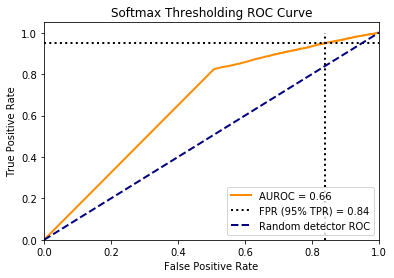

In [10]:
labels = [1] * num_inliers + [0] * num_imagenet_crop
predictions = cifar_model_maximums + imagenet_crop_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Imagenet (crop)"] = stats
df.loc['imagenet_crop'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Tiny Imagenet (Resize)

In [11]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_resize = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
#     transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
imagenet_resize_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(directory, transform=transform_resize),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_imagenet_resize = len(imagenet_resize_loader.dataset.imgs)

# Get predictions on in-distribution images
imagenet_resize_model_maximums = get_max_model_outputs(imagenet_resize_loader, device)

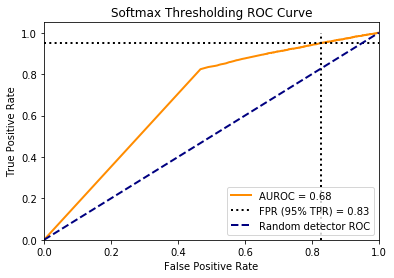

In [12]:
labels = [1] * num_inliers + [0] * num_imagenet_resize
predictions = cifar_model_maximums + imagenet_resize_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Imagenet (resize)"] = stats
df.loc['imagenet_resize'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### LSUN (Crop)

In [13]:
lsun_directory = '/media/tadenoud/DATADisk/datasets/lsun'

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
lsun_crop_loader = torch.utils.data.DataLoader(
    datasets.LSUN(lsun_directory, classes='test', transform=transform_crop),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_lsun_crop = len(lsun_crop_loader.dataset)

# Get predictions on in-distribution images
lsun_crop_model_maximums = get_max_model_outputs(lsun_crop_loader, device)

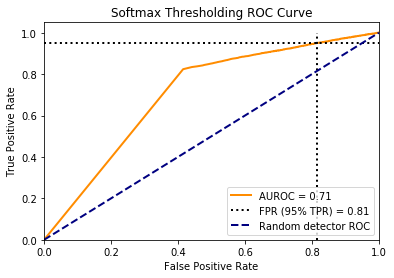

In [14]:
labels = [1] * num_inliers + [0] * num_lsun_crop
predictions = cifar_model_maximums + lsun_crop_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["LSUN (crop)"] = stats
df.loc['lsun_crop'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### LSUN (Resize)

In [15]:
# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
lsun_resize_loader = torch.utils.data.DataLoader(
    datasets.LSUN(lsun_directory, classes='test', transform=transform_resize),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_lsun_resize = len(lsun_resize_loader.dataset)

# Get predictions on in-distribution images
lsun_resize_model_maximums = get_max_model_outputs(lsun_resize_loader, device)

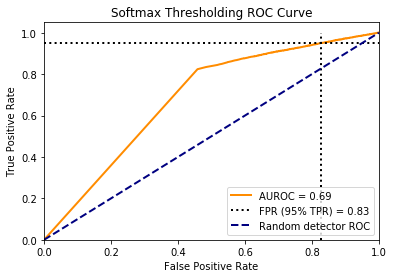

In [16]:
labels = [1] * num_inliers + [0] * num_lsun_resize
predictions = cifar_model_maximums + lsun_resize_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["LSUN (resize)"] = stats
df.loc['lsun_resize'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### iSUN

In [17]:
isun_directory = '/media/tadenoud/DATADisk/datasets/isun'

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
isun_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(isun_directory, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_isun = len(isun_loader.dataset)

# Get predictions on in-distribution images
isun_model_maximums = get_max_model_outputs(isun_loader, device)

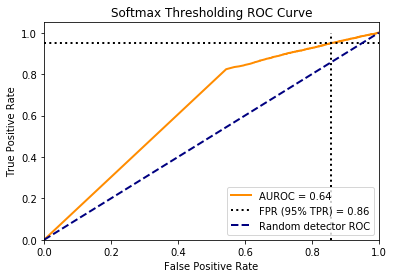

In [18]:
labels = [1] * num_inliers + [0] * num_isun
predictions = cifar_model_maximums + isun_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["iSUN"] = stats
df.loc['isun_resize'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Gaussian Noise Dataset

In [19]:
from novelty.utils.datasets import GaussianNoiseDataset

class InvertNormalize(object):
    """Undoes the operation performed using transforms.Normalize using the same MEAN and STD arrays."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be inverse normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


gaussian_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor(),
    InvertNormalize(CHANNEL_MEANS, CHANNEL_STDS)
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
gaussian_loader = torch.utils.data.DataLoader(
    GaussianNoiseDataset((10000, 32, 32, 3), mean=0., std=1., transform=gaussian_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_gaussian = len(gaussian_loader.dataset)

# Get predictions on in-distribution images
gaussian_model_maximums = get_max_model_outputs(gaussian_loader, device)

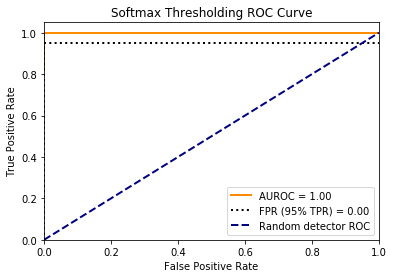

In [20]:
labels = [1] * num_inliers + [0] * num_gaussian
predictions = cifar_model_maximums + gaussian_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Gaussian Noise"] = stats
df.loc['gaussian'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Uniform Noise Dataset

In [21]:
from novelty.utils.datasets import UniformNoiseDataset
import math

uniform_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor(),
    InvertNormalize(CHANNEL_MEANS, CHANNEL_STDS)
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
uniform_loader = torch.utils.data.DataLoader(
    UniformNoiseDataset((10000, 32, 32, 3), low=-math.sqrt(3.), high=math.sqrt(3.), transform=uniform_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_uniform = len(uniform_loader.dataset)

# Get predictions on in-distribution images
uniform_model_maximums = get_max_model_outputs(uniform_loader, device)

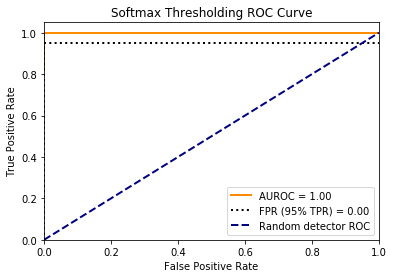

In [22]:
labels = [1] * num_inliers + [0] * num_uniform
predictions = cifar_model_maximums + uniform_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Uniform Noise"] = stats
df.loc['uniform'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

# Show Results Table

In [23]:
from IPython.display import HTML, display

table = html_summary_table(results)
display(HTML(table))

In [24]:
df.to_pickle('./results/cifar10_lee2018.pkl')
df

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
imagenet_crop,0.660345,0.764655,0.685128,0.839500,0.444750
imagenet_resize,0.681399,0.774329,0.702087,0.826000,0.438000
lsun_crop,0.706653,0.786921,0.721176,0.814000,0.432000
lsun_resize,0.685517,0.776342,0.705308,0.826600,0.438300
isun_resize,0.641185,0.772362,0.641431,0.857255,0.453627
gaussian,1.000000,1.000000,1.000000,0.000000,0.000000
uniform,1.000000,1.000000,1.000000,0.000000,0.000000


In [63]:
def score_accuracy(model, test_loader, device):
    num_correct = 0
    
    for x, y in test_loader:
        preds = predict(model, x, device)
        preds = np.argmax(preds.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        
        num_correct += np.array(preds == y).astype(np.int8).sum()
    
    return num_correct / len(test_loader.dataset)
        
score = score_accuracy(model, test_loader, device)

print("Accuracy: %.2f%%" % (score * 100))

Accuracy: 83.03%
